# Korišćenje neuronskih mreža u regresionim zadacima

Zadatak:
 - dizajnirati i istrenirati neuronsku mrežu za predikciju cena nekretnina
 - skup podataka: Boston Housing dataset
 - dizajn rešenja: neuronska mreža sa propagacijom unapred

In [1]:
import torch
import numpy as np

SEED = 7
# za determinističko izvršavanje sveske:
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

## Priprema skupa podataka

*Boston housing* je skup podataka namenjen razviju modele za predviđanje cena nekretnina u Bostonu. Sadrži 13 različitih atributa koji obuhvataju različite aspekte stambenih objekata i njihovih okolina. Atributi uključuju, između ostalog, površinu nekretnine, broj soba, stopu kriminala u oblasti, pristup putevima i poreze. Više o ovom skupu podataka možete pročitati [ovde](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html).

In [2]:
import pandas as pd

data = pd.read_csv('data/boston.csv')

In [3]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [4]:
data.shape

(506, 14)

In [5]:
from sklearn import model_selection

X = data.drop(columns=['MEDV'])
y = data['MEDV']
X_train_valid, X_test, y_train_valid, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=7)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train_valid, y_train_valid, test_size=0.1, random_state=7)

In [6]:
print("X_train", X_train.shape, type(X_train))
print("y_train", y_train.shape, type(y_train))
print("X_valid", X_valid.shape, type(X_valid))
print("y_valid", y_valid.shape, type(y_valid))
print("X_test", X_test.shape, type(X_test))
print("y_test", y_test.shape, type(y_test))

X_train (305, 13) <class 'pandas.core.frame.DataFrame'>
y_train (305,) <class 'pandas.core.series.Series'>
X_valid (34, 13) <class 'pandas.core.frame.DataFrame'>
y_valid (34,) <class 'pandas.core.series.Series'>
X_test (167, 13) <class 'pandas.core.frame.DataFrame'>
y_test (167,) <class 'pandas.core.series.Series'>


Nakon učitavanja, podatke ćemo i standardizovati.

In [7]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [8]:
print("X_train", X_train.shape, type(X_train), sep='\t')
print("y_train", y_train.shape, type(y_train), sep='\t')
print("X_valid", X_valid.shape, type(X_valid), sep='\t')
print("y_valid", y_valid.shape, type(y_valid), sep='\t')
print("X_test", X_test.shape, type(X_test), sep='\t')
print("y_test", y_test.shape, type(y_test), sep='\t')

X_train	(305, 13)	<class 'numpy.ndarray'>
y_train	(305,)	<class 'pandas.core.series.Series'>
X_valid	(34, 13)	<class 'numpy.ndarray'>
y_valid	(34,)	<class 'pandas.core.series.Series'>
X_test	(167, 13)	<class 'numpy.ndarray'>
y_test	(167,)	<class 'pandas.core.series.Series'>


Kako torch biblioteka ne radi sa pandas objektima, prebacicemo ciljnu promenjivu u numpy

### Kreiranje mreže

Mreža koju ćemo napraviti će biti mreža sa propagacijom unapred. Ulaz u mrežu biće vektor dimenzije 13. Mreža će imati jedan skriveni sloj sa 100 neurona. Izlazni sloj imaće jedan neuron jer mreža treba da predvidi cenu nekretnine. Za aktivacionu funkciju skrivenog sloja odabraćemo `ReLu`, dok ćemo za drugi, izlazni sloj, izostaviti aktivaionu funkciju što je standardni izbor u slučajevima regresionih zadataka. Aktivaciona funkcija bi ograničavala opseg koje mreža može da nauči što je u suprotnosti sa očekivanjima regresionih zadataka. 

In [9]:
number_of_features = X_train.shape[1]
output_size = 1

In [10]:
import torch.nn as nn

class RegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(RegressionModel, self).__init__()
        layers = [
            nn.Linear(input_size, 100),
            nn.ReLU(),
            nn.Linear(100, output_size),
        ]
        self.model = nn.Sequential(*layers)

        # self.apply(self.init_weights)

    def forward(self, x):     
        return self.model(x)
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

In [11]:
model = RegressionModel(number_of_features, output_size)
print(model)
print("Broj parametara modela: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

RegressionModel(
  (model): Sequential(
    (0): Linear(in_features=13, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)
Broj parametara modela:  1501


## Treniranje mreže

U regresionim zadacima za funkciju greške najčešće koristimo srednjekvadratnu grešku (engl. mean squared error). Pored nje od interesa nam mogu biti i druge metrike. Jedna od čestih metrika koje pratimo je srednja apsolutna greška (eng. mean absolute error). 

Mrežu ćemo trenirati u 100 epoha sa paketićima veličine 32 instance. Ovoga puta ćemo postaviti i `verbose` parametar funkcije na vrednost 1 kako bismo mogli da pratimo ispise u toku izvršavanja funkcije.

In [12]:
N_EPOCHS = 200
BATCH_SIZE = 32

In [13]:
from torch.utils.data import TensorDataset, DataLoader

X_train, y_train = torch.FloatTensor(X_train), torch.FloatTensor(y_train.to_numpy())
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

X_valid, y_valid = torch.FloatTensor(X_valid), torch.FloatTensor(y_valid.to_numpy())
valid_dataset = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
from torch.optim import Adam
from tqdm.notebook import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

optimizer = Adam(params=model.parameters(), lr=0.001)
metrics = defaultdict(lambda: {'train': [], 'valid': []})

for epoch in tqdm(range(N_EPOCHS), leave=True, desc='Epochs'):
    epoch_train_loss, epoch_train_mae, train_samples = 0, 0, 0
    epoch_valid_loss, epoch_valid_mae, valid_samples = 0, 0, 0
    
    # Koraci treninga
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.size(0)

        optimizer.zero_grad()
        
        # BITNO: .squeeze je neophodan zbok broadcasting pravila!
        predictions = model(inputs).squeeze()
        loss = (predictions - labels).pow(2).mean()
        mae = (predictions - labels).abs().mean()
        
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * batch_size
        epoch_train_mae += mae.item() * batch_size
        train_samples += batch_size

    # Računanje metrika na validacionom skupu
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            batch_size = inputs.size(0)

            
            predictions = model(inputs).squeeze()
            loss = (predictions - labels).pow(2).mean()
            mae = (predictions - labels).abs().mean()
            
            epoch_valid_loss += loss.item() * batch_size
            epoch_valid_mae += mae.item() * batch_size
            valid_samples += batch_size

    # Average metrics for the epoch
    avg_train_loss = epoch_train_loss / train_samples
    avg_train_mae = epoch_train_mae / train_samples
    avg_valid_loss = epoch_valid_loss / valid_samples
    avg_valid_mae = epoch_valid_mae / valid_samples
    
    metrics['loss']['train'].append(avg_train_loss)
    metrics['mae']['train'].append(avg_train_mae)
    metrics['loss']['valid'].append(avg_valid_loss)
    metrics['mae']['valid'].append(avg_valid_mae)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

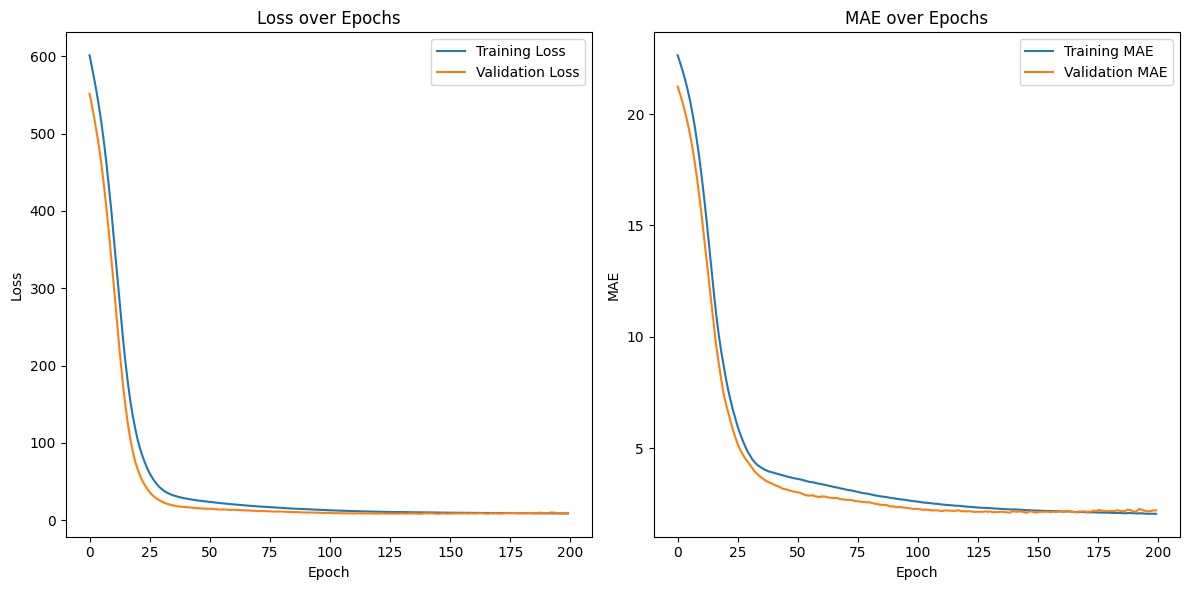

In [15]:

# Plotting metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(metrics['loss']['train'], label='Training Loss')
axes[0].plot(metrics['loss']['valid'], label='Validation Loss')
axes[0].set_title('Loss over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(metrics['mae']['train'], label='Training MAE')
axes[1].plot(metrics['mae']['valid'], label='Validation MAE')
axes[1].set_title('MAE over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()

plt.tight_layout()
plt.show()


## Evaluacija mreže

In [16]:
X_test, y_test = torch.FloatTensor(X_test), torch.FloatTensor(y_test.to_numpy())
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [17]:
model.eval()
test_mse, test_mae, test_samples = 0, 0, 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.size(0)

        
        predictions = model(inputs).squeeze()
        mse = (predictions - labels).pow(2).mean()
        mae = (predictions - labels).abs().mean()
        
        test_mse += mse.item() * batch_size
        test_mae += mae.item() * batch_size
        test_samples += batch_size
test_mse /= test_samples
test_mae /= test_samples
print(f"{test_mae=}")
print(f"{test_mse=}")

  0%|          | 0/6 [00:00<?, ?it/s]

test_mae=2.4577108899990243
test_mse=14.864125217506272


Ukoliko su nam potrebne i druge metrike evaluacije, možemo iskoristiti funkcije biblioteke `scikit-learn`.

In [18]:
from sklearn import metrics

In [19]:
model.eval()
with torch.no_grad():
    y_predicted = model(X_test.to(device)).cpu().numpy()

In [20]:
metrics.r2_score(y_test, y_predicted)

0.8041242774873658

Analizom grafika funkcije greške možemo zaključiti da je došlo do malog preprilagođavanja modela. Greška na trening skupu je nastavila da opada, dok je greška na validacionom skupu stagnirala. 

Ovo nije poželjno, tako da možemo iskoristiti tehniku ranog zaustavljanja treninga (eng. early stopping). Ukoliko najbolja greška na validacionom skupu prestane da opada možemo zaustaviti trening.

Modifikovaćemo kod za trening kako bi uveli ovu heuristiku:

In [21]:
model2 = RegressionModel(number_of_features, output_size)
model2.to(device)
optimizer = Adam(params=model2.parameters(), lr=0.001)
metrics2 = defaultdict(lambda: {'train': [], 'valid': []})

best_val_loss = float('inf')
early_stopping_patience = 10  # broj epoha koji čekamo na poboljšanje
eps = 1e-5                    # minimalno poboljšanje koje očekujemo
steps_since_improvment = 0

for epoch in tqdm(range(N_EPOCHS), leave=True, desc='Epochs'):
    epoch_train_loss, epoch_train_mae, train_samples = 0, 0, 0
    epoch_valid_loss, epoch_valid_mae, valid_samples = 0, 0, 0
    
    # Koraci treninga
    model2.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.size(0)

        optimizer.zero_grad()
        
        # BITNO: .squeeze je neophodan zbok broadcasting pravila!
        predictions = model2(inputs).squeeze()
        loss = (predictions - labels).pow(2).mean()
        mae = (predictions - labels).abs().mean()
        
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * batch_size
        epoch_train_mae += mae.item() * batch_size
        train_samples += batch_size

    # Računanje metrika na validacionom skupu
    model2.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            batch_size = inputs.size(0)

            
            predictions = model2(inputs).squeeze()
            loss = (predictions - labels).pow(2).mean()
            mae = (predictions - labels).abs().mean()
            
            epoch_valid_loss += loss.item() * batch_size
            epoch_valid_mae += mae.item() * batch_size
            valid_samples += batch_size

    # Average metrics for the epoch
    avg_train_loss = epoch_train_loss / train_samples
    avg_train_mae = epoch_train_mae / train_samples
    avg_valid_loss = epoch_valid_loss / valid_samples
    avg_valid_mae = epoch_valid_mae / valid_samples
    
    metrics2['loss']['train'].append(avg_train_loss)
    metrics2['mae']['train'].append(avg_train_mae)
    metrics2['loss']['valid'].append(avg_valid_loss)
    metrics2['mae']['valid'].append(avg_valid_mae)

    # Deo koda posvećen ranom zaustavljanju:
    if best_val_loss > avg_valid_loss + eps:
        best_val_loss = avg_valid_loss
        steps_since_improvment = 0
    else:
        steps_since_improvment += 1
        if steps_since_improvment == early_stopping_patience:
            print("\nEARLY STOPPING\n")
            break

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]


EARLY STOPPING



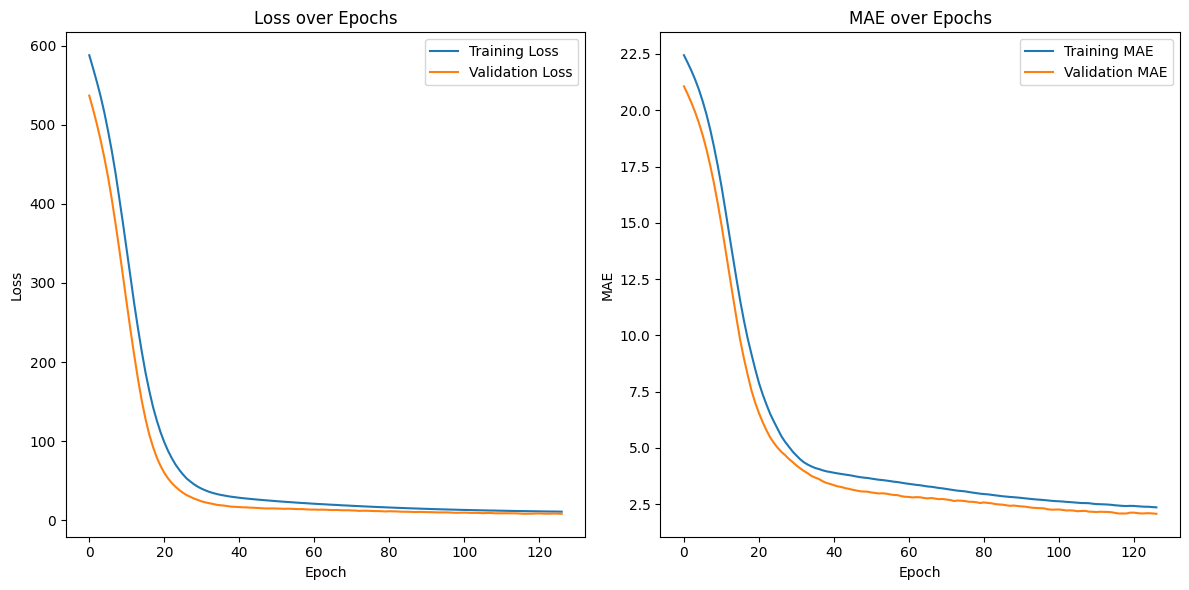

In [22]:

# Plotting metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(metrics2['loss']['train'], label='Training Loss')
axes[0].plot(metrics2['loss']['valid'], label='Validation Loss')
axes[0].set_title('Loss over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(metrics2['mae']['train'], label='Training MAE')
axes[1].plot(metrics2['mae']['valid'], label='Validation MAE')
axes[1].set_title('MAE over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()

plt.tight_layout()
plt.show()


In [23]:
model2.eval()
test_mse, test_mae, test_samples = 0, 0, 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.size(0)

        
        predictions = model2(inputs).squeeze()
        mse = (predictions - labels).pow(2).mean()
        mae = (predictions - labels).abs().mean()
        
        test_mse += mse.item() * batch_size
        test_mae += mae.item() * batch_size
        test_samples += batch_size
test_mse /= test_samples
test_mae /= test_samples
print(f"{test_mae=}")
print(f"{test_mse=}")

  0%|          | 0/6 [00:00<?, ?it/s]

test_mae=2.669456072196275
test_mse=17.11546444750118


## Čuvanje modela

Kao što smo napomenuli, za svaki sloj mreže postoji matrica parametara i matrica slobodnih članova. Sve parametre modela, kao i njegove slobodne članove možemo dobit pozivom funckije `model.state_dict()`.

In [24]:
print(model.state_dict().keys())
print(type(model.state_dict()))


odict_keys(['model.0.weight', 'model.0.bias', 'model.2.weight', 'model.2.bias'])
<class 'collections.OrderedDict'>


In [25]:
for weight_name in model.state_dict():
    print(weight_name, model.state_dict()[weight_name].shape)

model.0.weight torch.Size([100, 13])
model.0.bias torch.Size([100])
model.2.weight torch.Size([1, 100])
model.2.bias torch.Size([1])


Pozivom funkcije `torch.save` možemo čuvati vrednosti parametara modela, kao i cele modele. Fajlove koje kreiramo pozivom `torch.save` funkcije se po konvenciji koriste `.pth` ekstenziju.

In [26]:
torch.save(model.state_dict(), 'saved_models/model.pth')

In [27]:
torch.save(model, 'saved_models/model_full.pth')

Fajl napravljen `torch.save` funkcijom možemo pročitati funkcijom `torch.load`.

In [28]:
model_revived = torch.load('saved_models/model_full.pth')

In [29]:
model.load_state_dict(torch.load('saved_models/model.pth'))

<All keys matched successfully>

Učitani model se može koristiti na način na koji smo to do sada i radili. 

Zajednica koja se bavi mašinskim učenjem ulaže napore da standardizuje formate za čuvanje mreža. Jedan od njih je i [ONNX](https://onnx.ai/) za koji torch biblioteka nudi [podršku](https://pytorch.org/docs/stable/onnx.html). O ovim temam će svakako biti više reči i u nastavku kursa. 
<img src='assets/onnx.png'>

In [30]:
torch.onnx.export(model, torch.randn(1, number_of_features, device=device),f="model.onnx")

Ukoliko nam je potreban uvid u samu arhitekturu mreže, možemo generisati i grafički prikaz korišćenjem biblioteke torchviz. Za ova generisanja nam je potrebna i bibliteka `graphviz`.

In [31]:
from torchviz import make_dot 

dummy_input = torch.randn(1, number_of_features).to(device)
output = model(dummy_input)
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("model_pytorch", format="png")

'model_pytorch.png'

Vizuelizacije mreže će biti moguće i kroz alat [TensorBoard](https://www.tensorflow.org/tensorboard) koji ćemo, takođe, upoznati na nekom od narednih časova.